In [1]:
IMG_BASE="/home/jovyan/host/home/p-workbench/Statistics-for-Engineers/img/"
from IPython.core.display import Image

# Latency SLOs done right

In their excellent SLO-workshop at SRECon2018 ([program](https://www.usenix.org/conference/srecon18europe/presentation/fong-jones-0)) Liz Fong-Jones, Kristina Bennett and Stephen Thorne (Google) presented some best practice examples for Latency SLI/SLOs. At Circonus we care deeply about measuring latency and SRE techniques such as SLI/SLOs. As we will explain here, Latency SLOs are particularly delicate to implement and benefit from having Histogram-data available to  understand distributions and adjust SLO targets.

## Latency SLI

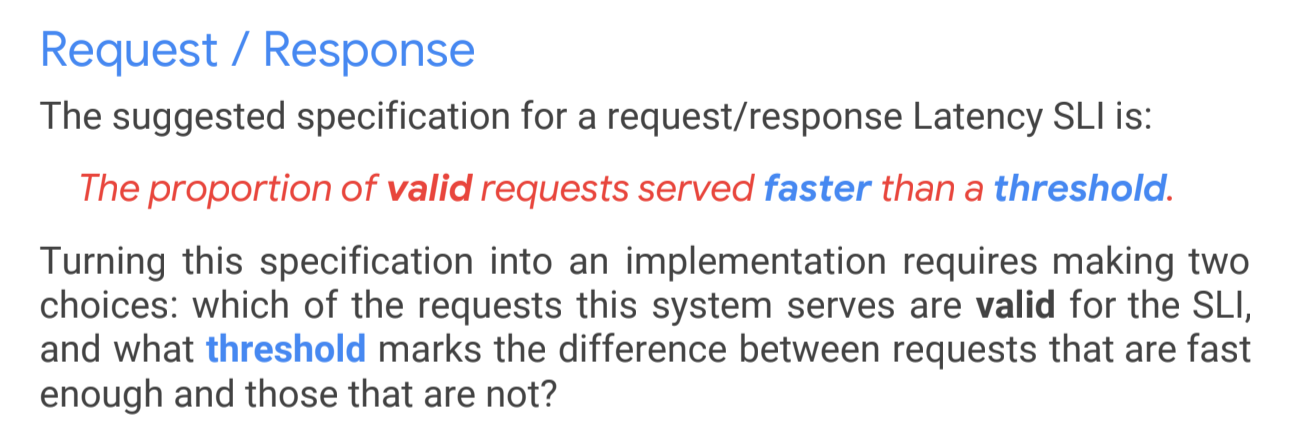

In [2]:
Image(data=IMG_BASE+"LatencySLI.png", width=600)

## Latency SLO

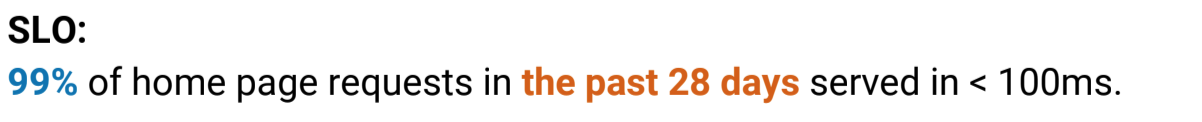

In [4]:
Image(data=IMG_BASE+"LatencySLO.png", width=600)

## Latency Metrics

These days latency is very typically measured with percentile metrics like these, which were presented for a similar use case:

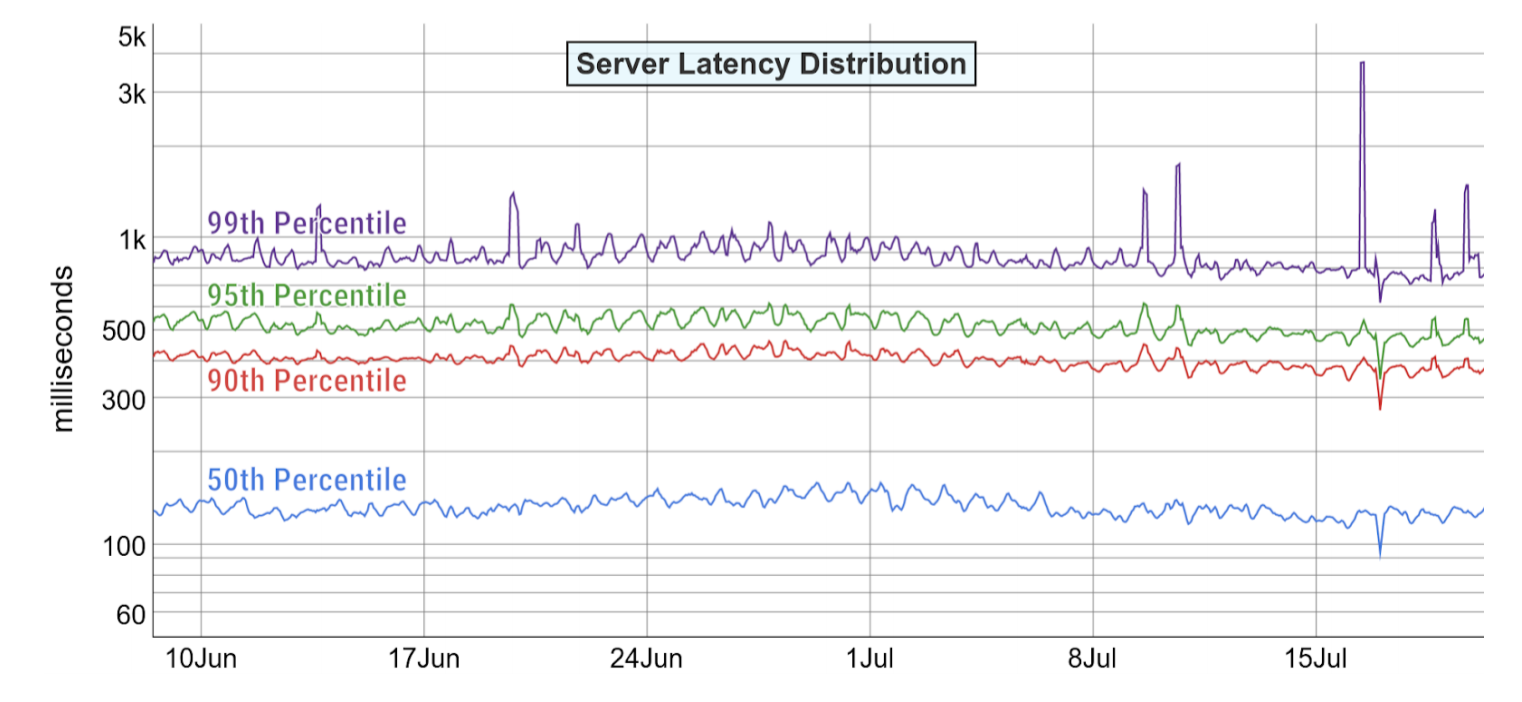

In [5]:
Image(data=IMG_BASE+"LatencyPcts.png")

Given this data, what can we say about the SLO? 

> What is the p90 computed over the full 28days?

It's very tempting to take the average of the p90 metric which is displayed in the graph, which would be just below the 500ms mark.

It's important to note, and it was correclty pointed out during the session, that this is not generally true.
You have no mathematical way determine the 28day-percentile from the series of 1h(?)-percentiles that are shown on the above graphs ([reddit](https://www.reddit.com/r/devops/comments/941n2k/tsdbs_at_scale_part_one/e3po8d3/
), [blog](www.circonus.com/problem-math/), [math](https://github.com/HeinrichHartmann/Statistics-for-Engineers/blob/master/2018-08-29-SRECon-Duesseldorf/3%20Data%20Aggregation%20Methods.ipynb)).
You need to look at different metrics if you want to implement a latency SLO. 
In this post we will discuss three different methods how to do this correctly.

## Another Example

In the example above the error of averaging percentile might actually not be that dramatic.
The system seems to be very well-behaved with a very high constant load. 
In this situation like this the average p90/1h is typically close to the total p90/28days.

So let's look at another API, which is less constantly loaded system.
This API does barely serve any load between 2:00am and 4:00am:

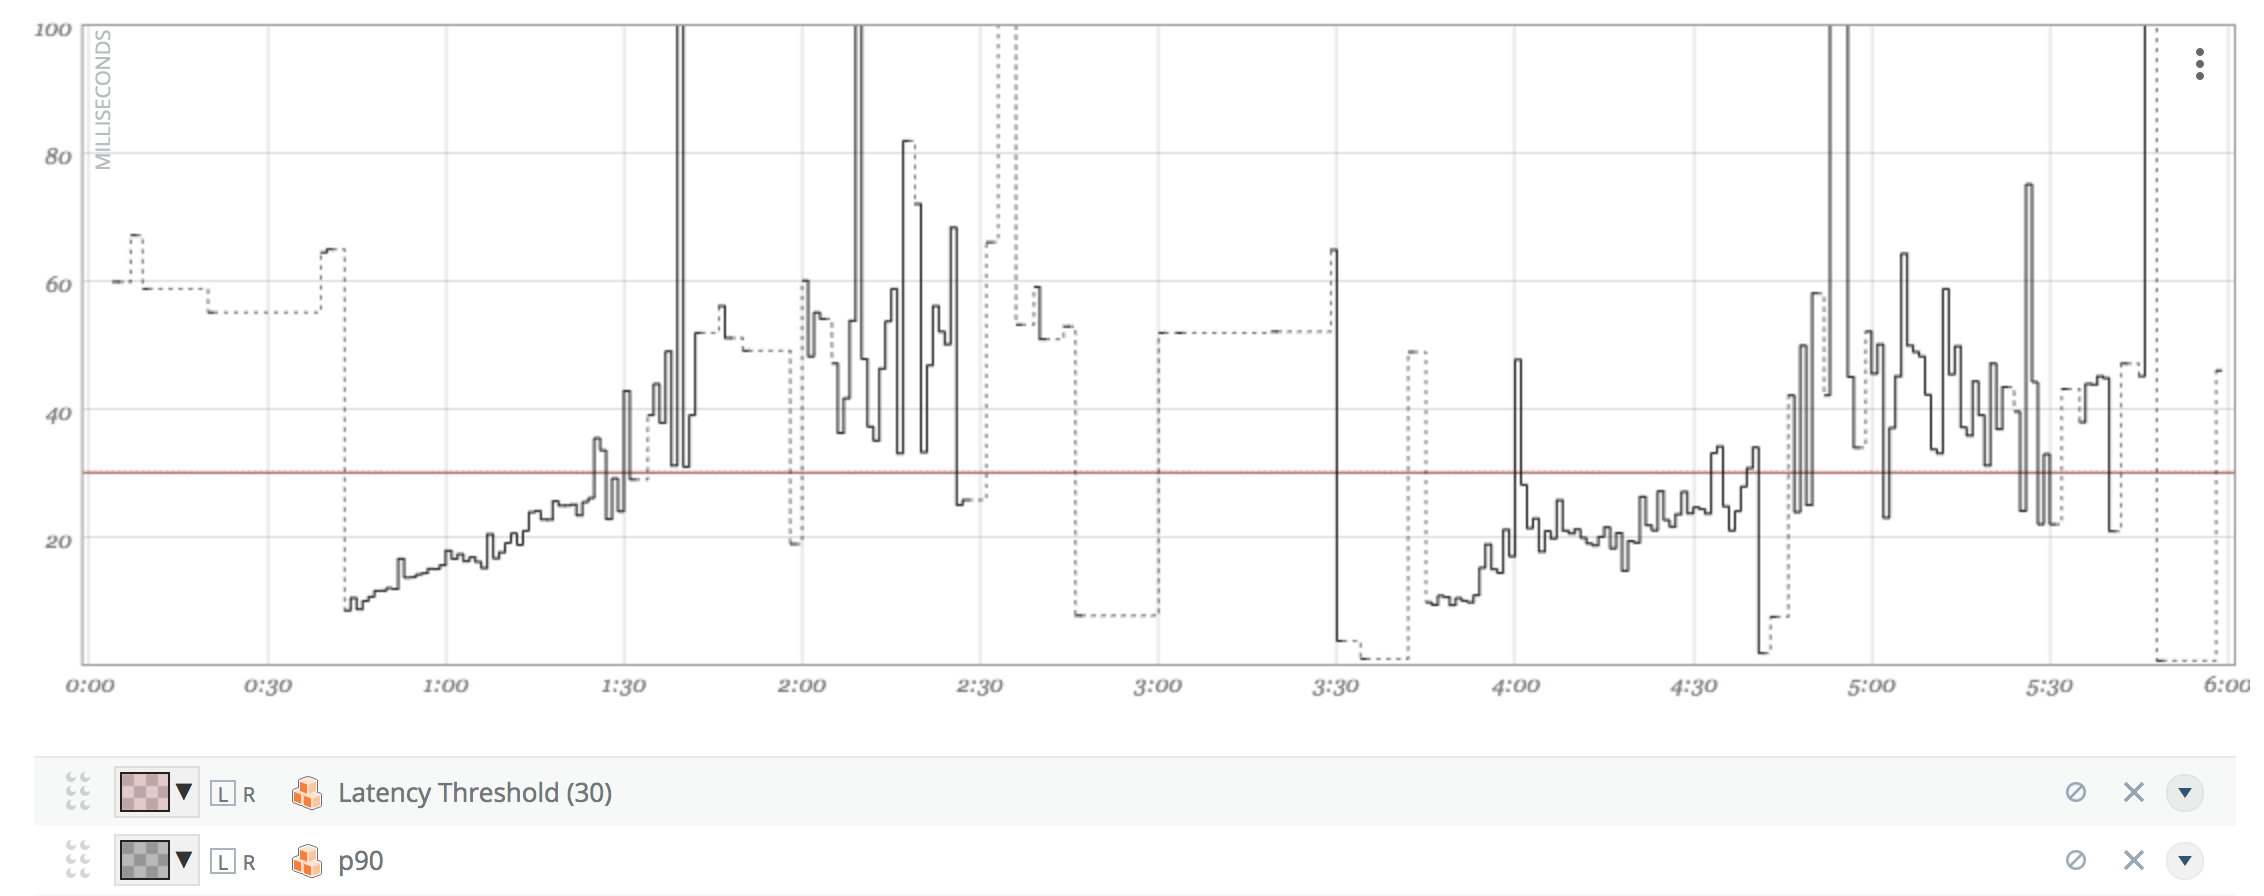

In [6]:
Image(data=IMG_BASE+"SLIp90.png")

What's the true p90 over the 6h drawn on the graph? Is it above or below 30ms?

The average p90/1M (36.28ms) looks far less appealing then before.

## Computing Latency SLOs

So how to do better? There are three ways to go about this:

(1) compute the SLO from stored raw data (logs)

(2) count the number of bad requests in a separate metric

(3) use histograms to store latency distribution.

## Method 1: Using Raw/Log data

Storing access logs with latency data is clearly possible and gives you accurate results.
The drawback with this approach is that you must keep your logs over long time periods (28days) which can be very (very) expensive.

## Method 2: Counting bad requests

For the first case you will need to instrument you application to count the number of requests that violated your threshold.
The resulting metrics will look like this:

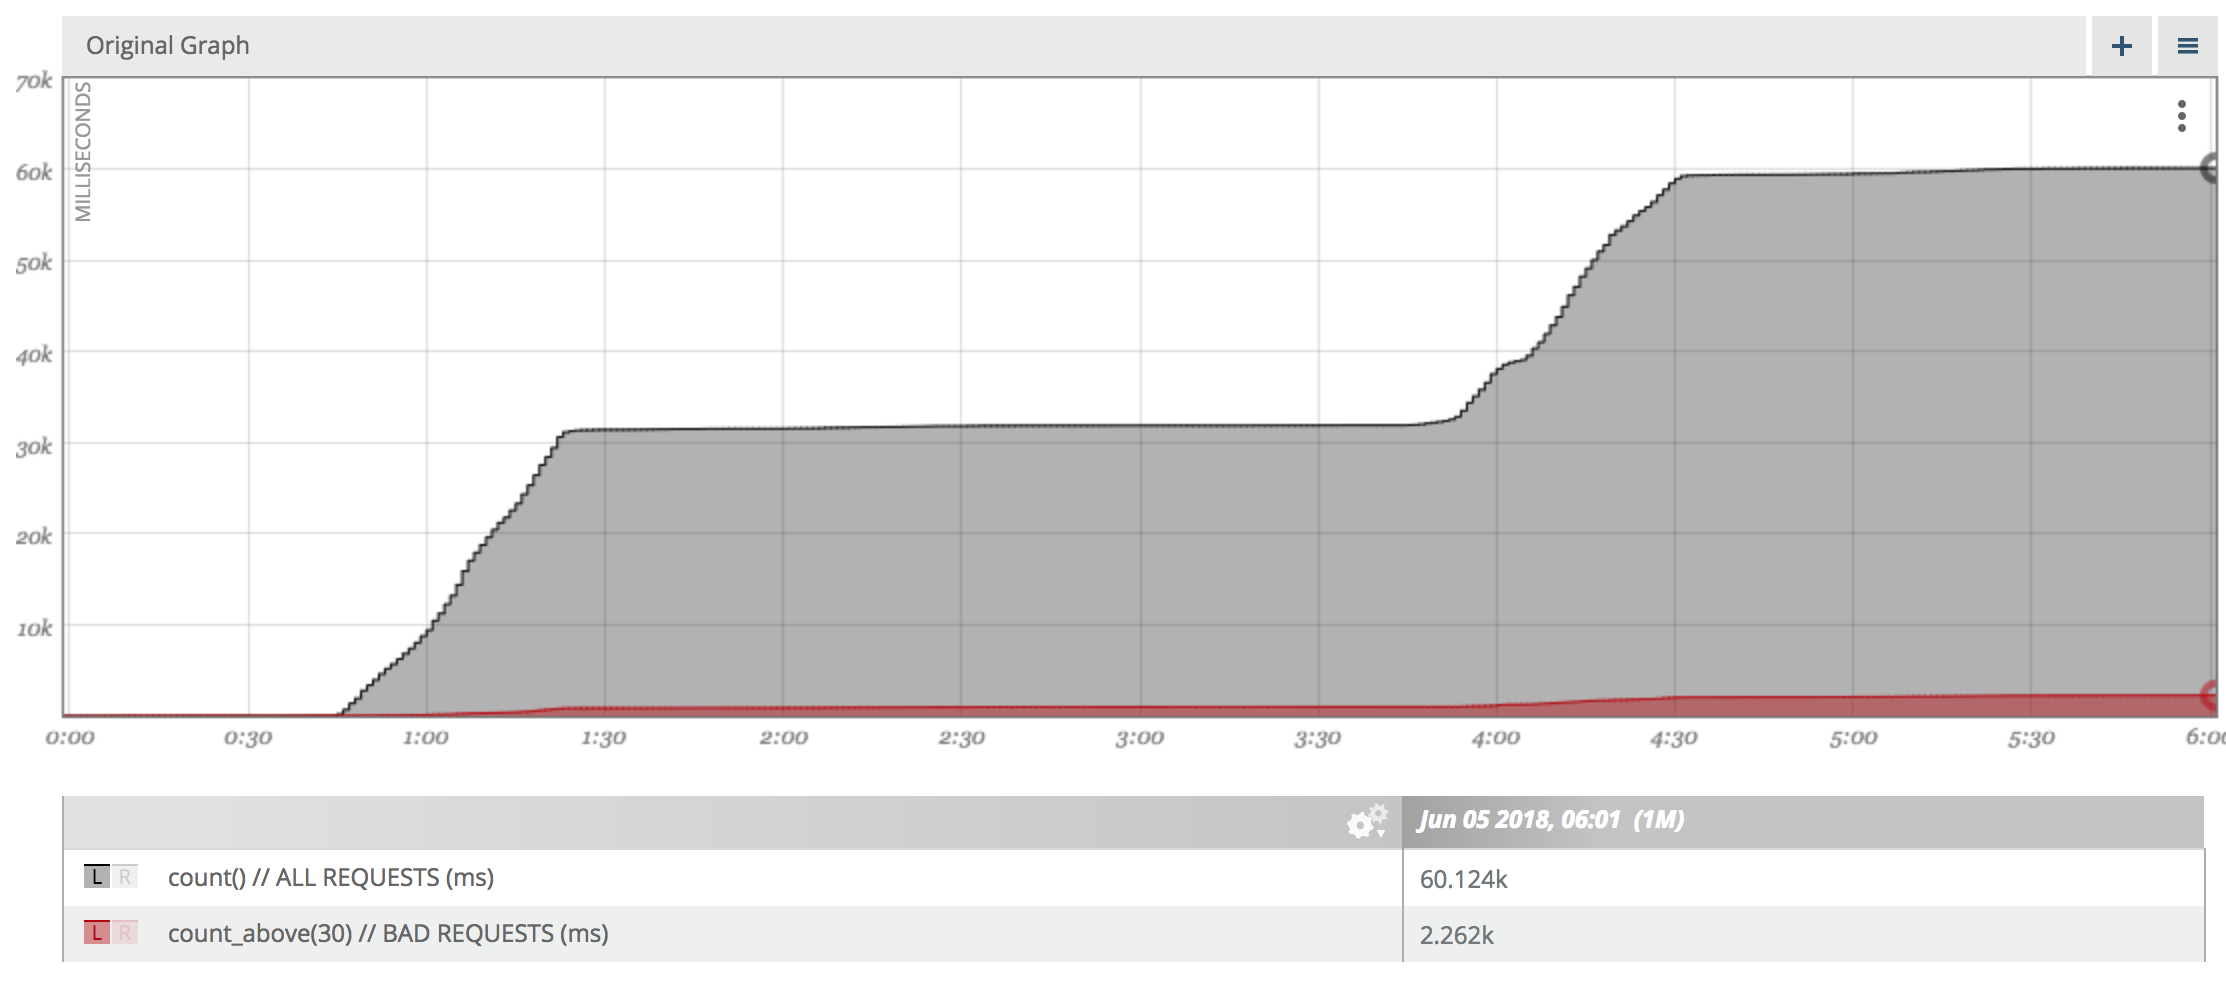

In [7]:
Image(data=IMG_BASE+"SLI_count_bad.png")

In [12]:
count_total=60124
count_bad=2262
count_good=count_total - count_bad
percent_good = count_good/count_total * 100
print("Percent good = {}/{} = {:.3f}%".format(count_good, count_total, percent_good))

Percent good = 57862/60124 = 96.238%


Using this metrics we see that 96% of our requests over the past 6h were faster than 30ms. 
Our SLO stated, that 90% of the requests should be good.
So we met that objective.

The drawbacks of this appraoch is that you have to chosse the latency threshold upfront.
There is no way to calculate the percentage of requests that were faster than say 200ms form the recorded data.

If your SLO changes, you will need to change the executable or the service configuation to count requests above a different threshold.

## Method 3: Storing Histograms

The third practical option you have for computing accurate SLOs is storing your request latency data as histograms.
The advantage of storing latency data as histograms are that:

(1) Histograms can be freely aggregated across time.

(2) Histograms can be used to derive approximations of arbitrary percentiles.

For (1) to be true, it's critical, that your histograms have common bin choices.
It's usually a good idea to mandate the bin boundaries for your whole organization.
Otherwise you will not be able to aggregate histograms from different services.

For (2) it's critical that you have enough bins in the latency range that is relevant for your percentile.
Sparsely encoded log linear histograms allow you to cover a large floating point range (E.g. `10^-127..10^128`) with a fixed relative precision (E.g. 5%).
In this way you can guarantee 5% accuracy on all percentiles, no matter how the data is distributed.

Two popular implementations of log linear histograms are:

* HDR-Histogram - https://HDrhistogram.org
* Circllhist - https://github.com/circonus-labs/libcircllhist/

[Circonus](https://circonus.com) (where I work) comes with native support for Circllhist and will be used for this example.

Histogram metrics store latency information per minute, and are commonly visualized as heatmap:

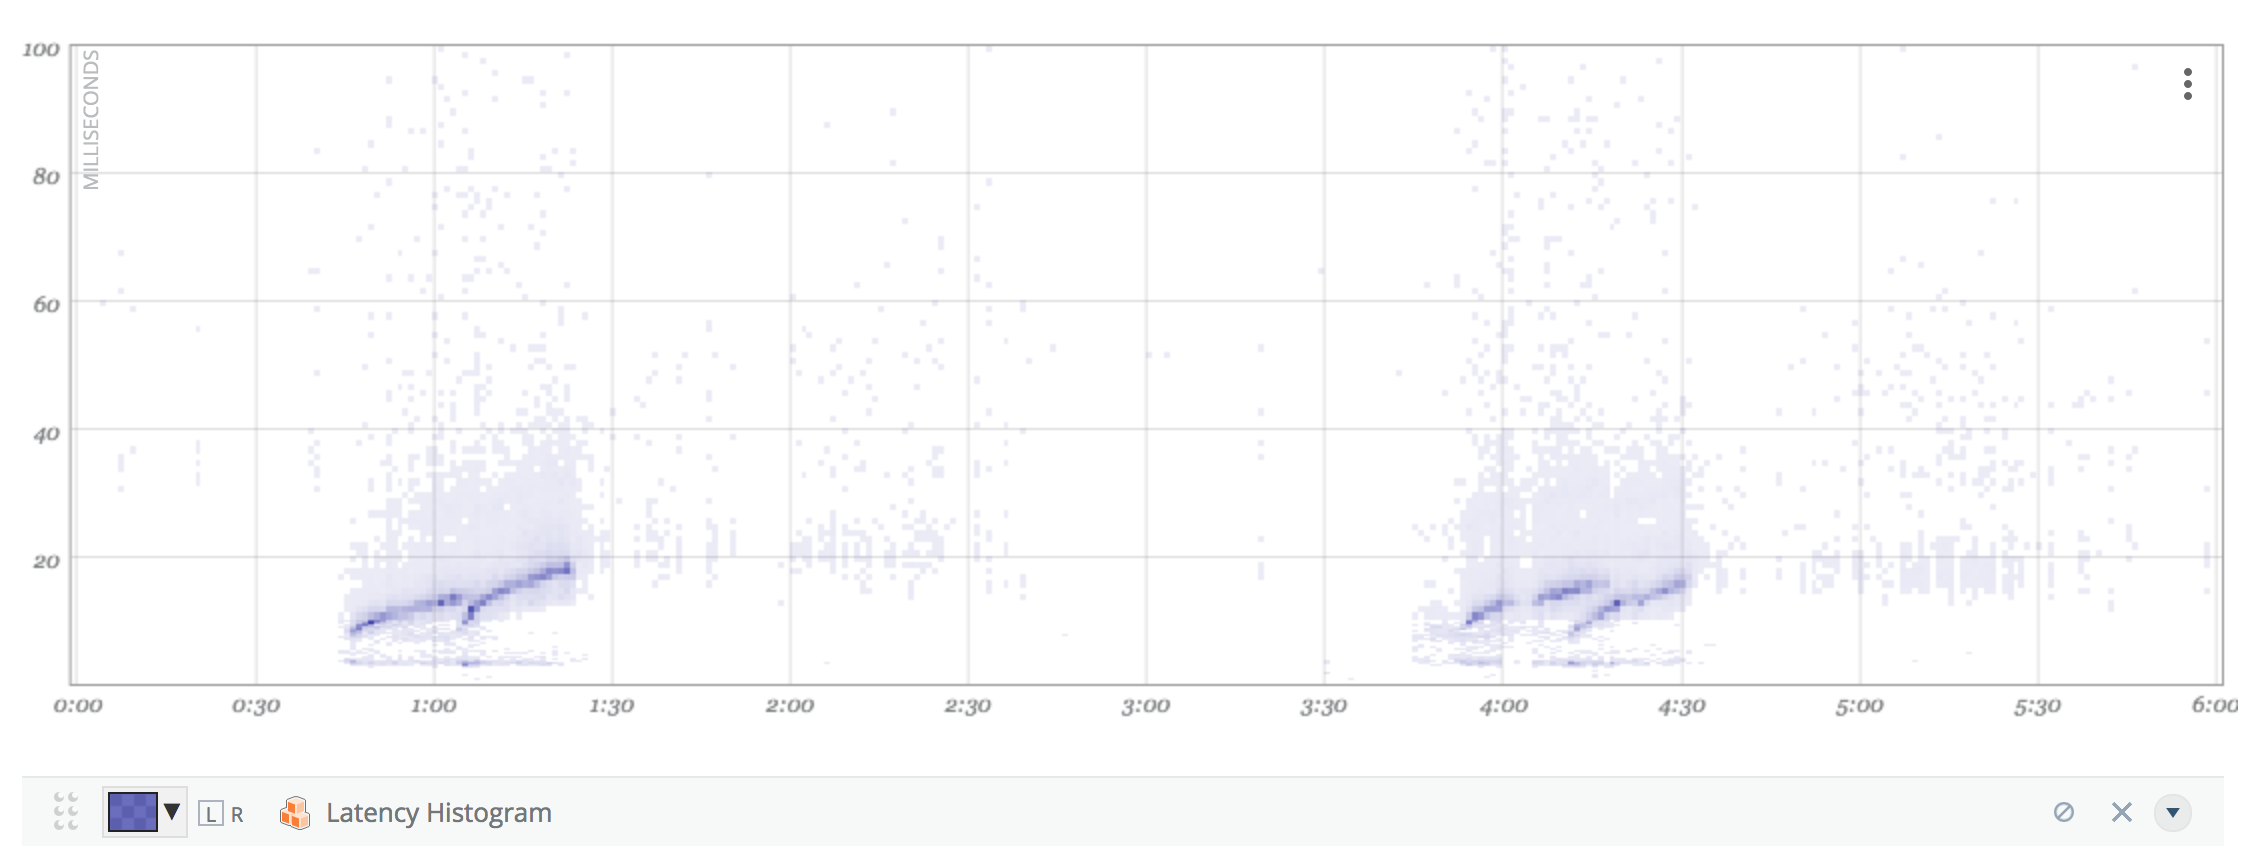

In [13]:
Image(data=IMG_BASE+"SLI_hist.png")

Merging those 360x1M-histograms shown above into a single 6h-Histogram, we arrive at the following graph:

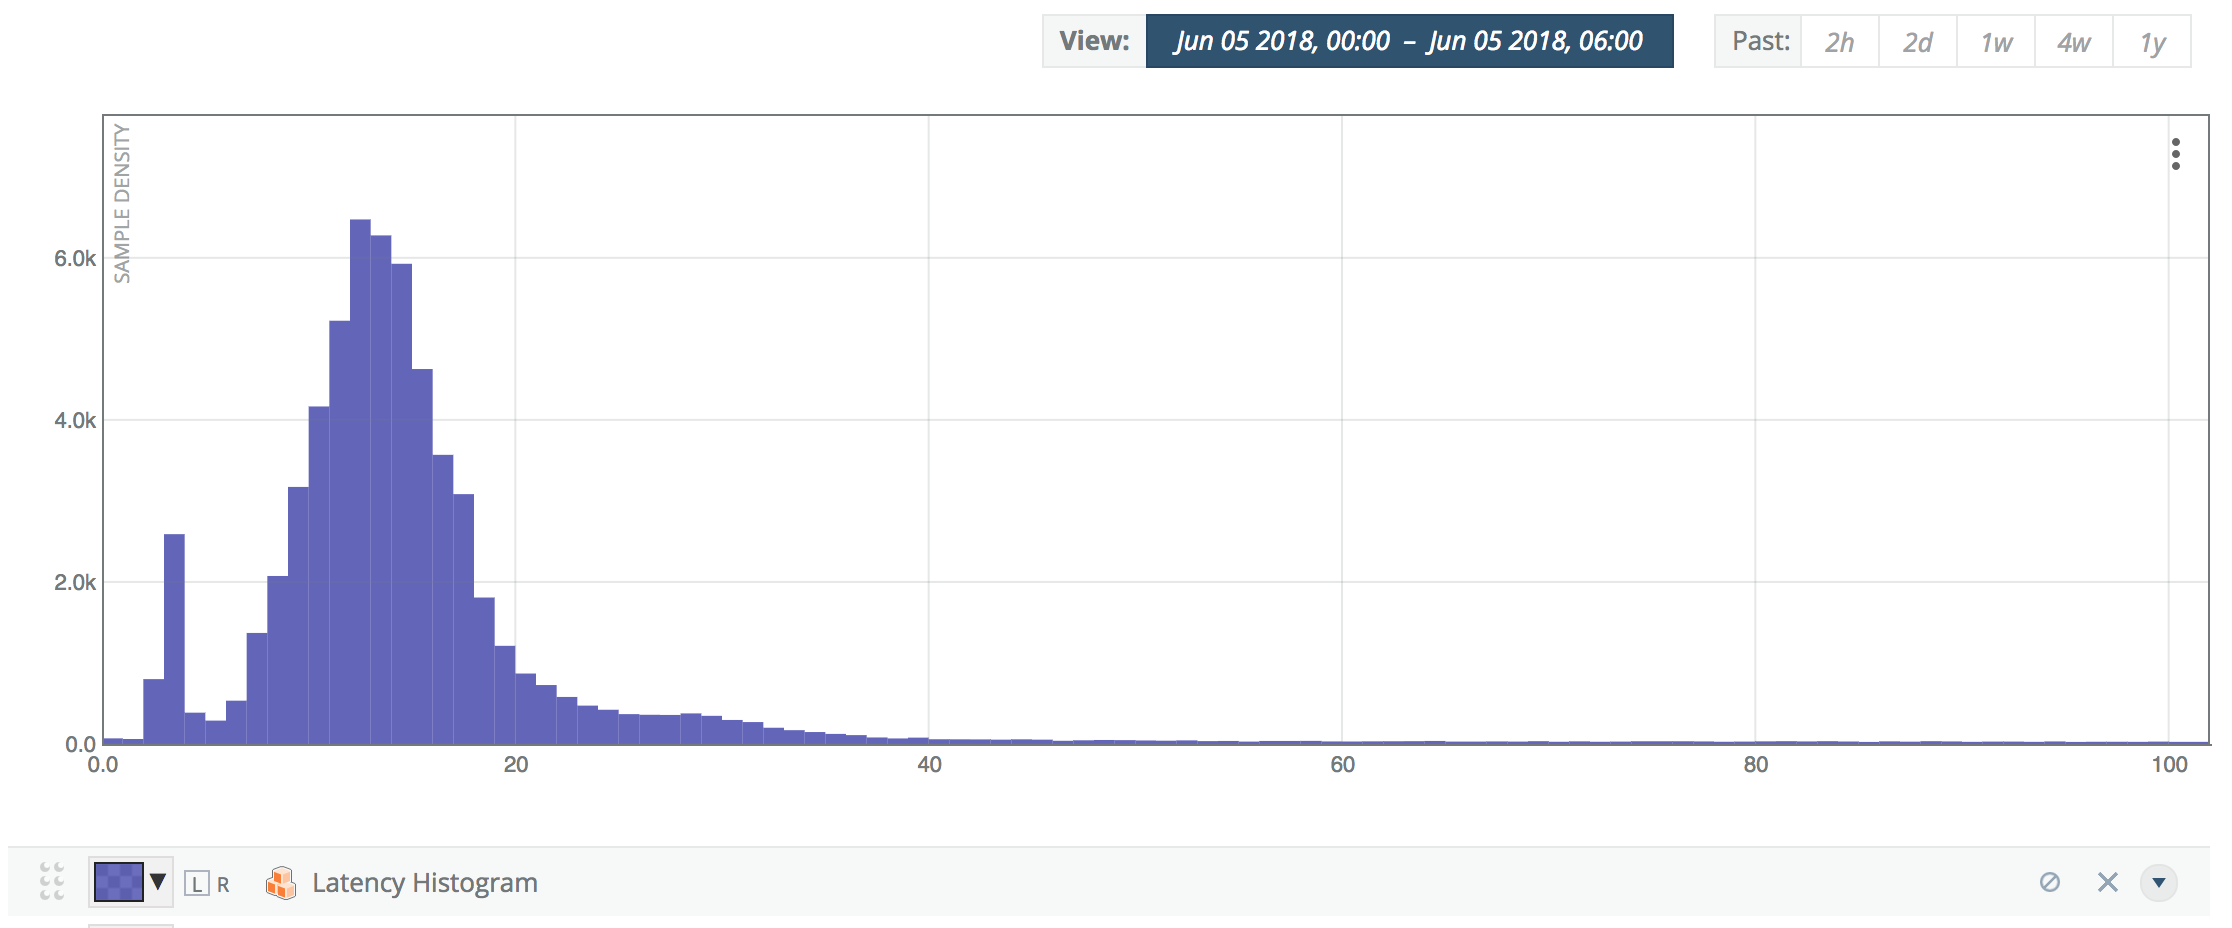

In [14]:
Image(data=IMG_BASE+"SLI_hist_global.png")

This is the true latency distribution over the full SLO reporting period of 6h (in this case).

At the time of this writing, there is no nice UI option to overlay percentiles in the above histogram graph.
As we will see, you can perform the SLO calculation with CAQL or Python.

### SLO Reporting via CAQL

We can use the CAQL functions `histogram:rolling(6h)` and `histogram:percentile()` to aggregate histograms over the last 6h and compute precentiles over the aggregated histograms. 
The SLO value we are looking for will be the very last value displayed on the graph.

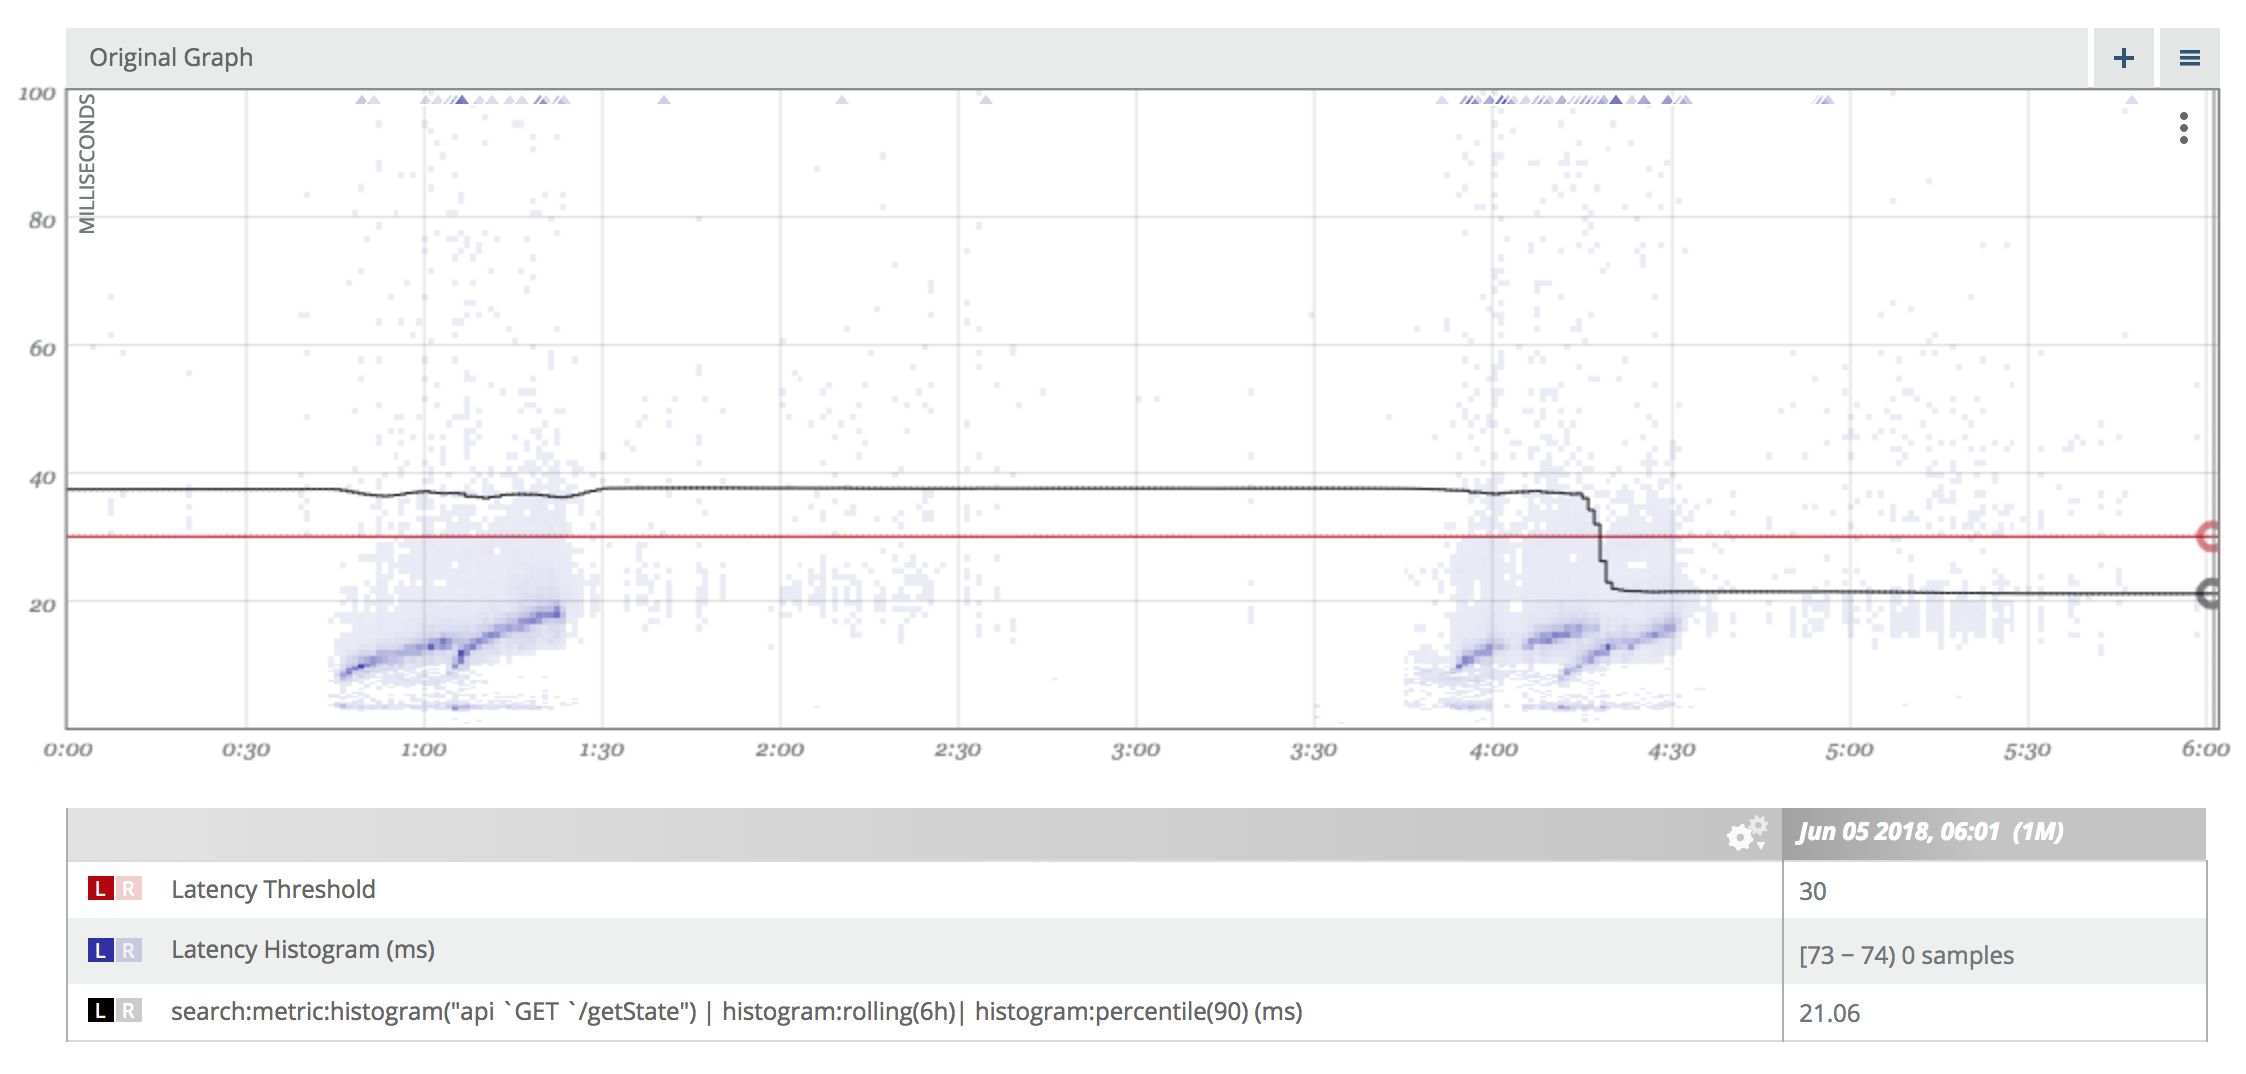

In [15]:
Image(data=IMG_BASE+"SLI_hist_percentiles.png")

### SLO Reporting using Python

Using the Python API the calculation could look as follows:

In [268]:
# 0. Setup Python
%matplotlib inline
from circonusapi import circonusdata
from circllhist import Circllhist
with open(os.path.expanduser("~/host/home/.circonusrc.json"),"r") as fh:
    config = json.load(fh)

In [269]:
# 1. Fetch Histogram Data
t = 1528171020 # exact start time of the graph 
N = 364        # exact number of minutes on the above graph
circ = circonusdata.CirconusData(config["demo"])
data = circ.caql('search:metric:histogram("api`GET`/getState")', t, 60, N)

In [270]:
# 2. Merge Histograms
H=Circllhist()
for h in data['output[0]']: H.merge(h)

(0, 100)

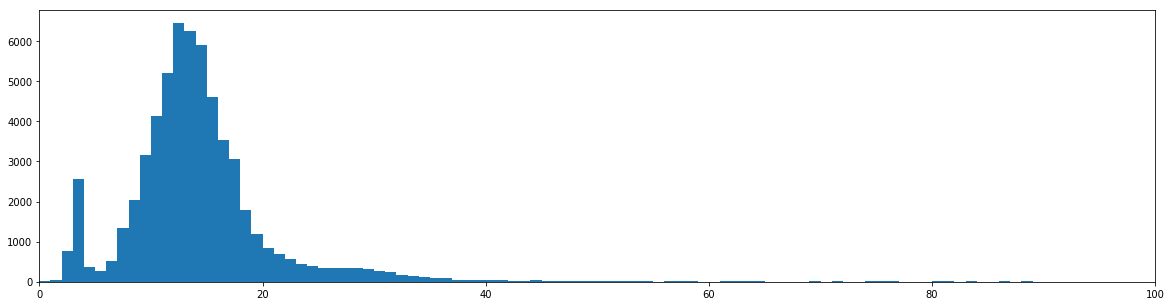

In [271]:
# Let's check the fetched data is consistent with Histogram in the UI
plt.figure(figsize=(20,5))
circllhist_plot(H)
plt.xlim(0,100)

In [275]:
# 3. Calculate Aggregated Precentiles:
P = [50, 90, 95, 99, 99.9] # arbitrary percentiles
for p in P: print("{:>8}-latency percentile over 6h: {:>8.3f}ms".format(p, H.quantile(p/100)))

      50-latency percentile over 6h:   13.507ms
      90-latency percentile over 6h:   21.065ms
      95-latency percentile over 6h:   27.796ms
      99-latency percentile over 6h:   56.058ms
    99.9-latency percentile over 6h:  918.760ms


In particular we see that the true p90 is around 21ms, which is far away from the average p90 of 36.28 we computed earlier.

In [276]:
# 4. Calculate Aggregated Counts:
Y = [10, 30, 50, 100, 200] # Arbitrary thresholds
for y in Y: print("{:>10.3f} percent faster than {}ms".format(H.count_below(y)/H.count()*100,y))

    18.465 percent faster than 10ms
    96.238 percent faster than 30ms
    98.859 percent faster than 50ms
    99.484 percent faster than 100ms
    99.649 percent faster than 200ms


In particular we replicate the "96.238% below 30ms" result, that we calculated using the counter metrics before.

# Conclusion

It's imporant to understand that percentile metrics do not allow you to implement accurate Service Level Objectives that are forumlated against hours or weeks.
Aggregating 1M-percentiles seems tempting but can produce materially wrong results, in particular if your load is highly volatile.

Practical ways to calculate correct SLO percentiles are counters and histograms.
Histograms give you additional flexibility to choose the latency threshold after the fact.
This comes in particularly handy when you are still evaluating your service and are not ready to commit yourself to a latency threshold just yet.